In [29]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [30]:
# differential equation for ENSO
def recharge_deriv(y, t, mu=2./3, en=0, c = 1.0, r= 0.25, alpha = 0.125, b0 = 2.5, gamma = 0.75): 
    '''
    input : variables, coefficients
    '''
    b = b0*mu  # coupling coefficient     
    R = gamma*b-c # Bjerknes coefficient
    T_E, h_w = y
    dT_dt = R * T_E + gamma * h_w - en*(h_w + b*T_E)**3
    dh_dt = -r * h_w - alpha * b * T_E
    return [dT_dt, dh_dt]  

# define numerical method
def RKM_4th(f, y, t, h):
    '''
    4th order Runge-Kutta method
    input : 함수, y, t, h
    output : y
    '''
    c1 = h*np.array(f(y, t))
    c2 = h*np.array(f(y+c1/2, t+h/2))
    c3 = h*np.array(f(y+c2/2, t+h/2))
    c4 = h*np.array(f(y+c3, t+h))
    y += (c1 + 2*c2 + 2*c3 + c4) / 6
    return y

# constants
max_time, h, tscale = 300, 0.01, 2
t = np.linspace(0, max_time, int(max_time/h)) #30000개
y_4th = np.zeros((len(t), 2)) 

# initial conditions
y_4th[0] = [0.1,-0.1]

#solving for ODEs
start = time.time()
for i in range(len(t)-1):
    yy = RKM_4th(recharge_deriv, y_4th[i], t[i], h)
    y_4th[i+1]=yy
end = time.time()

# Extract the results
T_E, h_w = y_4th[:,0], y_4th[:,1]

print(f"time for RK4 method : {end - start:.5f} sec")

time for RK4 method : 0.44780 sec


In [31]:
mu, en = 2./3, 0
end_time = int(t.shape[0]/4) #7500
ts = t * tscale # tscale = 1/6

# Prepare simulation data 
numerical_soln = [T_E[:end_time:10], h_w[:end_time:10]] #750
numerical_data = np.zeros_like(numerical_soln)
tss = ts[:end_time:10] #750

# Adding gaussian noise to the simulation data = training data
numerical_data[0] = numerical_soln[0] + 0.01*np.random.randn(*numerical_soln[0].shape)
numerical_data[1] = numerical_soln[1] + 0.01*np.random.randn(*numerical_soln[1].shape)

In [32]:
# Prepare training data
t_train = tss.reshape(-1, 1)
T_E, h_W = numerical_data[0], numerical_data[1]
T_E_tr = T_E.reshape(-1, 1)
h_W_tr = h_W.reshape(-1, 1)


In [33]:
# Define the DNN model with 3 hidden layers
class DNN():
    def __init__(self, size, lr):
        self.size = size
        self.lr = lr 
        self.params = self.initialization()

    def initialization(self):
        input_size = self.size[0]
        hidden_size = self.size[1]
        output_size = self.size[2]
        #np.random.seed(42)
        params = {
            'W1' : np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size),
            'b1' : np.zeros((1, hidden_size)),
            'W2' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b2' : np.zeros((1, hidden_size)),
            'W3' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b3' : np.zeros((1, hidden_size)),
            'W4' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b4' : np.zeros((1, hidden_size)),
            'W5' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b5' : np.zeros((1, hidden_size)),
            'W6' : np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size),
            'b6' : np.zeros((1, output_size))
        }
        return params

    # Activation function (can be changed to tanh)
    def custom_activation(self, x, derivative=False):
        if derivative == True :
            return 2 * np.sin(x) * np.cos(x) + 1
            #return 1-(np.tanh(x))**2
        #return np.tanh(x)
        return np.sin(x) ** 2 + x
    

    # Forward pass
    def forward_pass(self, t):
        params = self.params
        params['I'] = t.reshape(-1,1)
        params['A1'] = np.dot(params['I'], params['W1']) + params['b1']
        params['R1'] = self.custom_activation(params['A1'])
        params['A2'] = np.dot(params['R1'], params['W2']) + params['b2']
        params['R2'] = self.custom_activation(params['A2'])
        params['A3']= np.dot(params['R2'], params['W3']) + params['b3']
        params['R3'] = self.custom_activation(params['A3'])
        params['A4']= np.dot(params['R3'], params['W4']) + params['b4']
        params['R4'] = self.custom_activation(params['A4'])
        params['A5']= np.dot(params['R4'], params['W5']) + params['b5']
        params['R5'] = self.custom_activation(params['A5'])
        params['O'] = np.dot(params['R5'], params['W6']) + params['b6']
        return params['O']

    # Mean squared error loss
    def loss_function(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # Gradient clipping function
    def clip_gradients(self, grad, clip_value):
        return np.clip(grad, -clip_value, clip_value)

    # Backward propagation
    def backward_pass(self, T_E_train, h_W_train, output):
        m = T_E_train.shape[0]
        params = self.params
        change_params = {}

        dL_dO = 2 * (output - np.hstack((T_E_train, h_W_train))) / m
        change_params['W6'] = np.dot(params['R5'].T, dL_dO)
        change_params['b6'] = np.sum(dL_dO, axis=0, keepdims=True)

        dL_dz5 = np.multiply(np.dot(dL_dO, params['W6'].T), self.custom_activation(params['A5'], derivative=True))
        change_params['W5'] = np.dot(params['R4'].T, dL_dz5)
        change_params['b5'] = np.sum(dL_dz5, axis=0, keepdims=True)

        dL_dz4 = np.multiply(np.dot(dL_dz5, params['W5'].T), self.custom_activation(params['A4'], derivative=True))
        change_params['W4'] = np.dot(params['R3'].T, dL_dz4)
        change_params['b4'] = np.sum(dL_dz5, axis=0, keepdims=True)
  
        dL_dz3 = np.multiply(np.dot(dL_dz4, params['W4'].T), self.custom_activation(params['A3'], derivative=True))
        change_params['W3'] = np.dot(params['R2'].T, dL_dz3)
        change_params['b3'] = np.sum(dL_dz3, axis=0, keepdims=True)
  
        dL_dz2 = np.multiply(np.dot(dL_dz3, params['W3'].T), self.custom_activation(params['A2'], derivative=True))
        change_params['W2'] = np.dot(params['R1'].T, dL_dz2)
        change_params['b2'] = np.sum(dL_dz2, axis=0, keepdims=True)
        
        dL_dz1 = np.multiply(np.dot(dL_dz2, params['W2'].T), self.custom_activation(params['A1'], derivative=True))
        change_params['W1'] = np.dot(params['I'].T, dL_dz1)
        change_params['b1'] = np.sum(dL_dz1, axis=0, keepdims=True)
        return change_params
    
    def update_network_params(self, changes_to_params, clip_value=1.0):
        # Clip gradients # Update parameters
        for key, value in changes_to_params.items():
            self.params[key] -= self.lr * self.clip_gradients(value, clip_value)

dnn = DNN(size=[1,256,2], lr=1e-6)
loss_list = []
epochs = 50000
# Training the DNN model
for epoch in range(epochs):
    #dnn.train()
    pred = dnn.forward_pass(t_train)
    loss = dnn.loss_function(np.hstack((T_E_tr, h_W_tr)), pred)
    loss_list.append(loss)
    changes_to_params = dnn.backward_pass(T_E_tr, h_W_tr, pred)
    dnn.update_network_params(changes_to_params)
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.7f}')


Epoch [200/50000], Loss: 0.6908649
Epoch [400/50000], Loss: 0.6285616
Epoch [600/50000], Loss: 0.5962129
Epoch [800/50000], Loss: 0.5715483
Epoch [1000/50000], Loss: 0.5499630
Epoch [1200/50000], Loss: 0.5329311
Epoch [1400/50000], Loss: 0.5182695
Epoch [1600/50000], Loss: 0.5048020
Epoch [1800/50000], Loss: 0.4922389
Epoch [2000/50000], Loss: 0.4806887
Epoch [2200/50000], Loss: 0.4701256
Epoch [2400/50000], Loss: 0.4603578
Epoch [2600/50000], Loss: 0.4512378
Epoch [2800/50000], Loss: 0.4426353
Epoch [3000/50000], Loss: 0.4344700
Epoch [3200/50000], Loss: 0.4266908
Epoch [3400/50000], Loss: 0.4192356
Epoch [3600/50000], Loss: 0.4120737
Epoch [3800/50000], Loss: 0.4052546
Epoch [4000/50000], Loss: 0.3988122
Epoch [4200/50000], Loss: 0.3927084
Epoch [4400/50000], Loss: 0.3868925
Epoch [4600/50000], Loss: 0.3813341
Epoch [4800/50000], Loss: 0.3760117
Epoch [5000/50000], Loss: 0.3709103
Epoch [5200/50000], Loss: 0.3660212
Epoch [5400/50000], Loss: 0.3613320
Epoch [5600/50000], Loss: 0.3568

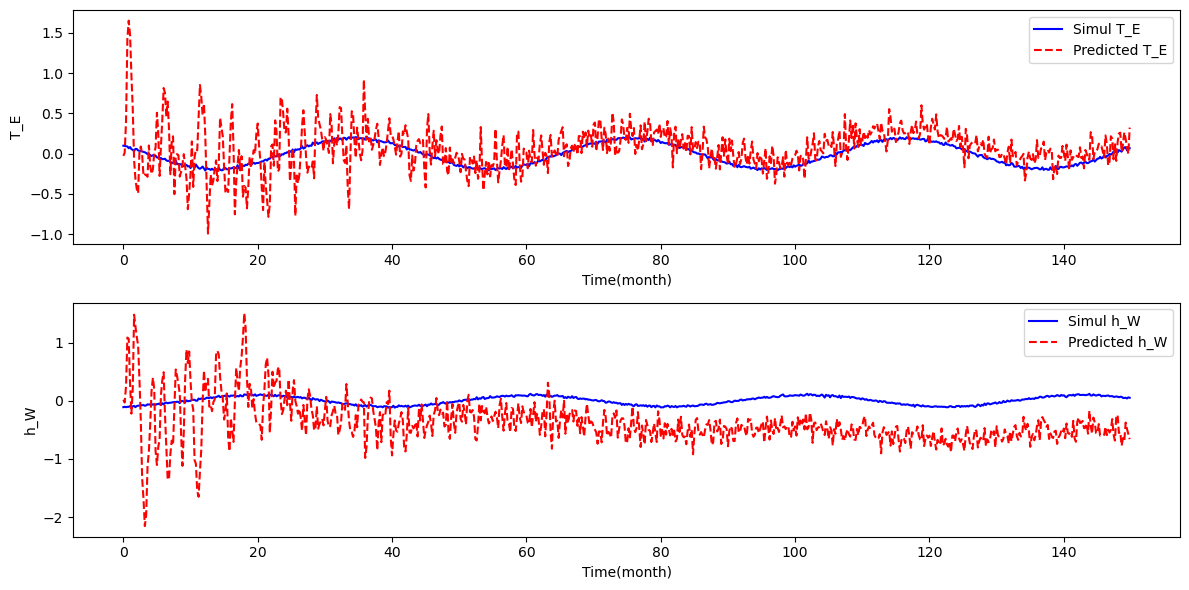

In [35]:

# Evaluate the model
output = dnn.forward_pass(t_train)
T_E_pred, h_W_pred = output[:, 0], output[:, 1]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tss, T_E, 'b-', label='Simul T_E')
plt.plot(tss, T_E_pred, 'r--', label='Predicted T_E')
plt.xlabel('Time(month)')
plt.ylabel('T_E')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tss, h_W, 'b-', label='Simul h_W')
plt.plot(tss, h_W_pred, 'r--', label='Predicted h_W')
plt.xlabel('Time(month)')
plt.ylabel('h_W')
plt.legend()

plt.tight_layout()
plt.show()


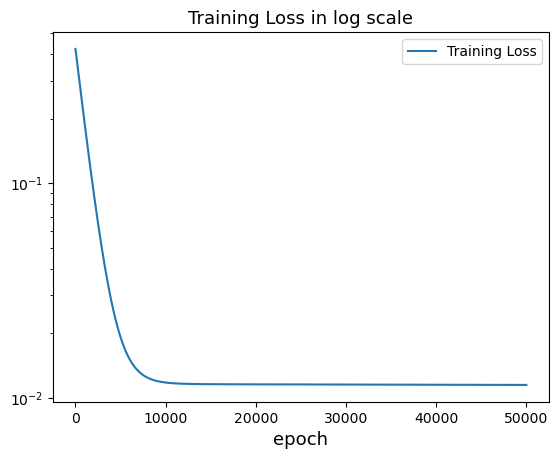

In [ ]:
plt.plot(loss_list, label='Training Loss')
plt.yscale('log')
plt.legend()
#plt.ylim(0.5,0.75) #제대로 줄어들지 않고 있음
plt.title('Training Loss in log scale', fontsize=13)
plt.xlabel('epoch', fontsize=13)
plt.show()